In [1]:
import numpy as np
import pandas as pd
from scipy.io import loadmat, mmread
import sys
import itertools 
import pickle
import matplotlib.pylab as plt
import time

/usr/local/lib/python3.4/dist-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


In [2]:
%matplotlib inline

In [3]:
import rankingmethod
import rankingmeasure

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from experiment import *

# Epinion

In [6]:
data = pd.read_csv("../datasets/soc-Epinions1.txt", sep='\t', header=4)
data = data.as_matrix()

In [167]:
data.shape

(508836, 2)

In [ ]:
#создание epinion удалив от туда пользователей, у которых количество отзывов меньше 25
#Также проводится переиндексанция пользователей и предметов

In [7]:
epinion, user_item = make_valid_data(data)

In [8]:
train, test, traintest = givenK_train_test(epinion, 10)

### изучение числа предметов у пользователей

In [ ]:
avr_len = 0
max_len = 0
for items in traintest:
    avr_len += len(items)
    max_len = max(len(items), max_len)
avr_len /= len(traintest)
print(avr_len)
print(max_len)

In [ ]:
list_len = []
for items in traintest:
    list_len.append(len(items))
list_len = np.array(list_len)

In [ ]:
np.sum(list_len > 1200)

In [ ]:
plt.hist(list_len, bins = 30)

In [ ]:
number_user_in_items = np.bincount(epinion[:, 1])

In [ ]:
plt.hist(np.bincount(epinion[:, 1]))

### подбор параметров для отдельных алгоритмов

In [201]:
poprec = rankingmethod.PopRec(user_item)
poprec.fit(train)
top = poprec.get_list(0)[:3]
# all_measures(train, test, poprec, True, top)
all_measures(train, test, poprec, True, top)

precK 0.0588422247446
1-call5 0.2551645856980704
MRR 0.115938619802
AUC 0.855322486831
NGDC 0.0407311022239
MAP 0.061123723042


In [13]:
rankingmeasure.get_Kmetrics(train, test, poprec, True)

array([ 0.19514188,  0.56821793,  0.22118543,  0.3911026 ])

### CLimf подбор параметров(не используя фичу авторов)

In [172]:
list_reg = np.linspace(0.001, 0.1, 10)#[0.001, 0.005, 0.01, 0.005 , 0.001] 
list_lrate = np.linspace(0.0001, 0.1, 10)#[0.01, 0.0001, 0.005, 0.01, 0.05, 0.1 ]

list_K = [10]

climf_validation = np.zeros((len(list_K), len(list_lrate), len(list_reg)))

for i, K in enumerate(list_K):
    for j, lrate in enumerate(list_lrate):
        for m, reg in enumerate(list_reg):
            climf = rankingmethod.CLiMF(user_item,K=K, reg=reg, lrate=lrate, verbose=0, maxiter=10)
            climf.fit(train)
            mrr = rankingmeasure.get_MRR(train, test, climf, skip_train=False)
            climf_validation[i,j,m] = mrr
            print(K, lrate, reg, "MRR", mrr)
            sys.stdout.flush()

10 0.0001 0.001 MRR 0.0140092330327
10 0.0001 0.012 MRR 0.0135188809706
10 0.0001 0.023 MRR 0.0110846816628
10 0.0001 0.034 MRR 0.0107559991743
10 0.0001 0.045 MRR 0.0125016096778
10 0.0001 0.056 MRR 0.0097490062225
10 0.0001 0.067 MRR 0.0196155666342
10 0.0001 0.078 MRR 0.0125674632419
10 0.0001 0.089 MRR 0.0148026707129
10 0.0001 0.1 MRR 0.0181875428327
10 0.0112 0.001 MRR 0.462160532413
10 0.0112 0.012 MRR 0.461658760365
10 0.0112 0.023 MRR 0.461436809265
10 0.0112 0.034 MRR 0.462120210144
10 0.0112 0.045 MRR 0.463179954148
10 0.0112 0.056 MRR 0.461855850935
10 0.0112 0.067 MRR 0.462665606148
10 0.0112 0.078 MRR 0.4616666994
10 0.0112 0.089 MRR 0.462509172004
10 0.0112 0.1 MRR 0.462446767785
10 0.0223 0.001 MRR 0.461498578823
10 0.0223 0.012 MRR 0.461793807862
10 0.0223 0.023 MRR 0.461345678599
10 0.0223 0.034 MRR 0.462987051736
10 0.0223 0.045 MRR 0.462801668006
10 0.0223 0.056 MRR 0.461848960198
10 0.0223 0.067 MRR 0.461870205979
10 0.0223 0.078 MRR 0.462608347186
10 0.0223 0.089 

In [183]:
index = np.unravel_index(np.argmax(climf_validation), climf_validation.shape)

In [184]:
print(list_reg[index[2]], list_lrate[index[1]])

0.067 0.0334


In [185]:
with open('climf_validation.pickle', 'wb') as f:
    pickle.dump(climf_validation, f)

In [ ]:
list_K = np.arange(25) + 2
reg = list_reg[index[2]]
lrate = list_lrate[index[1]] 
mrr = np.zeros(list_K.shape[0])
for i, K in enumerate(list_K):
    climf = rankingmethod.CLiMF(user_item,K=K, reg=reg, lrate=lrate, verbose=0, maxiter=10)
    climf.fit(train)
    mrr[i] = rankingmeasure.get_MRR(train, test, climf, skip_train=False)
#             climf_validation[i,j,m] = mrr
    print(K, lrate, reg, "MRR", mrr[i])
    sys.stdout.flush()

In [188]:
maxiter_list = np.arange(20)
mrr = np.zeros(list_K.shape[0])
for i, maxiter in enumerate(maxiter_list):
    climf = rankingmethod.CLiMF(user_item,K=5, reg=reg, lrate=lrate, verbose=0, maxiter=maxiter)
    climf.fit(train)
    mrr[i] = rankingmeasure.get_MRR(train, test, climf, skip_train=False)
#             climf_validation[i,j,m] = mrr
    print(K, lrate, reg, "MRR", mrr[i])
    sys.stdout.flush()

14 0.0334 0.067 MRR 0.0293517486082
14 0.0334 0.067 MRR 0.462491834065
14 0.0334 0.067 MRR 0.461515651855
14 0.0334 0.067 MRR 0.462351747218
14 0.0334 0.067 MRR 0.461624444276
14 0.0334 0.067 MRR 0.461470900033
14 0.0334 0.067 MRR 0.463152349079
14 0.0334 0.067 MRR 0.460893302907
14 0.0334 0.067 MRR 0.462571730744
14 0.0334 0.067 MRR 0.461625063196
14 0.0334 0.067 MRR 0.463749108164
14 0.0334 0.067 MRR 0.463029079769
14 0.0334 0.067 MRR 0.462177369818
14 0.0334 0.067 MRR 0.363057264257
14 0.0334 0.067 MRR 0.323813701683
14 0.0334 0.067 MRR 0.297059773632
14 0.0334 0.067 MRR 0.215761718408
14 0.0334 0.067 MRR 0.198497654652
14 0.0334 0.067 MRR 0.177414101413
14 0.0334 0.067 MRR 0.153797013474


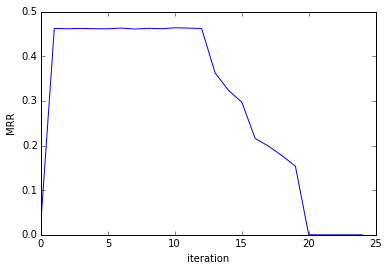

In [191]:
plt.plot(mrr)
plt.xlabel('iteration')
plt.ylabel('MRR')

### проверка работы авторского решения

In [195]:
create_csr(train, user_item, 'another_train.pickle')
create_csr(test, user_item, 'another_test.pickle')

### BPR_MF Подбор параметров

In [ ]:
list_reg = np.linspace(0.001, 0.1, 10)#[0.001, 0.005, 0.01, 0.005 , 0.001] 
list_lrate = np.linspace(0.001, 0.1, 10)
K = 10
res = np.zeros((len(list_lrate), len(list_reg)))

for j, lrate in enumerate(list_lrate):
    for m, reg in enumerate(list_reg):
        cf = rankingmethod.BPR_MF(user_item,K=K, regU=reg, regIpos=reg, regIneg=reg, 
                                  lrate=lrate, verbose=0, maxiter=4)
        cf.fit(train)
        res[j,m] = rankingmeasure.get_MAP(train, test, cf)
        print(lrate, reg, "MAP", res[j,m])
        sys.stdout.flush()

In [18]:
np.linspace(0.001, 0.1, 10)

array([ 0.001,  0.012,  0.023,  0.034,  0.045,  0.056,  0.067,  0.078,
        0.089,  0.1  ])

In [10]:
np.unravel_index(np.argmax(res), res.shape)

(1, 1)

In [21]:
list_K = np.arange(20) + 1#[0.001, 0.005, 0.01, 0.005 , 0.001] 

K = 10
reg = 0.012
lrate = 0.012
res = np.zeros(len(list_K))

for i, K in enumerate(list_K):
    cf = rankingmethod.BPR_MF(user_item,K=K, regU=reg, regIpos=reg, regIneg=reg, 
                              lrate=lrate, verbose=0, maxiter=4)
    cf.fit(train)
    res[i] = rankingmeasure.get_MAP(train, test, cf, K=5)
    print(lrate, reg, "MAP", res[i])
    sys.stdout.flush()

0.012 0.012 MAP 0.351807604994
0.012 0.012 MAP 0.350993504856
0.012 0.012 MAP 0.35005833018
0.012 0.012 MAP 0.351648694665
0.012 0.012 MAP 0.351482847774
0.012 0.012 MAP 0.351468028755
0.012 0.012 MAP 0.351119624164
0.012 0.012 MAP 0.35345440787
0.012 0.012 MAP 0.351319207971
0.012 0.012 MAP 0.354321478118
0.012 0.012 MAP 0.356043006684
0.012 0.012 MAP 0.351305650145
0.012 0.012 MAP 0.352099571194
0.012 0.012 MAP 0.357232627065
0.012 0.012 MAP 0.3515875268
0.012 0.012 MAP 0.356324568041
0.012 0.012 MAP 0.351335918779
0.012 0.012 MAP 0.351111426409
0.012 0.012 MAP 0.350964182116
0.012 0.012 MAP 0.355757661748


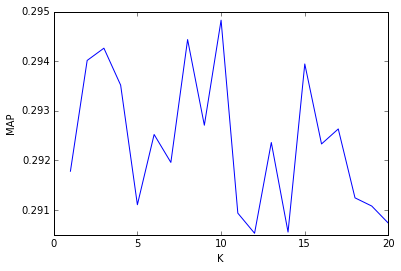

In [19]:
plt.plot(list_K, res)
plt.xlabel("K")
plt.ylabel("MAP")

In [ ]:
with open('bpr_mf_validation.pickle', 'wb') as f:
    f.dump(bpr_mf_validation, f)

In [238]:
maxiter_list = np.arange(11)
res = np.zeros(maxiter_list.shape[0])
for i, maxiter in enumerate(maxiter_list):
    cf = rankingmethod.BPR_MF(user_item,K = 20, lrate=0.001, regIpos=0.1, 
                              regIneg=0.1, regU=0.1, maxiter=maxiter, verbose=0)
    cf.fit(train)
    res[i] = rankingmeasure.get_MAP(train, test, cf, skip_train=False)
#             climf_validation[i,j,m] = mrr
    print(maxiter, "MAP", res[i])
    sys.stdout.flush()

0 MAP 0.0022020431328
1 MAP 0.322795434481
2 MAP 0.347745932652
3 MAP 0.343859881448
4 MAP 0.34203651154
5 MAP 0.343940282507
6 MAP 0.345028061546
7 MAP 0.341888321352
8 MAP 0.346355467272
9 MAP 0.347584499937
10 MAP 0.344234771093


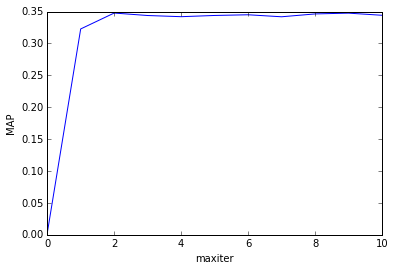

In [239]:
plt.plot(maxiter_list, res)
plt.xlabel("maxiter")
plt.ylabel("MAP")

### iMF Подбор  параметров

In [23]:
list_alpha = [0.5, 1,5,10, 20, 40, 80]
list_lmbd = [0.001, 0.005, 0.01, 0.05, 0.1]
K = 10

res = np.zeros((len(list_alpha), len(list_lmbd)))


for j, alpha in enumerate(list_alpha):
    for m, lmbd in enumerate(list_lmbd):
        cf = rankingmethod.iMF(user_item, K=K, lmbd=lmbd, alpha=alpha, maxiter=30, verbose=0)
        cf.fit(train)
        mrr = rankingmeasure.get_NDCG(train, test, cf)
        res[j,m] = mrr
        print(alpha, lmbd, "ND", mrr)
        sys.stdout.flush()

0.5 0.001 ND 0.17225625677
0.5 0.005 ND 0.170213342078
0.5 0.01 ND 0.172197871403
0.5 0.05 ND 0.173277549587
0.5 0.1 ND 0.178162825298
1 0.001 ND 0.172434512107
1 0.005 ND 0.172969389025
1 0.01 ND 0.172447180302
1 0.05 ND 0.170769485409
1 0.1 ND 0.17277434962
5 0.001 ND 0.199312607889
5 0.005 ND 0.196256153913
5 0.01 ND 0.20047934499
5 0.05 ND 0.199438120497
5 0.1 ND 0.199458930202
10 0.001 ND 0.21285789952
10 0.005 ND 0.210997645372
10 0.01 ND 0.203830960482
10 0.05 ND 0.212171018651
10 0.1 ND 0.210616920256
20 0.001 ND 0.22342160969
20 0.005 ND 0.225878493429
20 0.01 ND 0.220093226529
20 0.05 ND 0.231183857393
20 0.1 ND 0.225392019268
40 0.001 ND 0.240027475296
40 0.005 ND 0.236024108337
40 0.01 ND 0.230851237301
40 0.05 ND 0.232308361662
40 0.1 ND 0.238118641252
80 0.001 ND 0.241788371123
80 0.005 ND 0.239776452882
80 0.01 ND 0.233435053938
80 0.05 ND 0.232159036845
80 0.1 ND 0.236565193376


In [ ]:
with open('imf_validation.pickle', 'wb') as f:
    f.dump(imf_validation, f)

### TFMAP

In [200]:
list_reg = np.linspace(0.001, 0.1, 10)
list_lrate = np.linspace(0.001, 0.1, 10)
K = 10

tfmap_validation = np.zeros((len(list_reg), len(list_lrate)))

for i, reg in enumerate(list_reg):
    for j, lrate in enumerate(list_lrate):
        cf = rankingmethod.TFMAP(user_item, K=K, reg=reg, lrate=lrate, verbose = 0, maxiter=12)
        cf.fit(train)
        mp = rankingmeasure.get_MAP(train, test, cf)
        tfmap_validation[i,j] = mp
        print(K, reg, lrate, "MAP", mp)
        sys.stdout.flush()

10 0.001 0.001 MAP 0.0960631857737
10 0.001 0.012 MAP 0.357754130407
10 0.001 0.023 MAP 0.358363917266
10 0.001 0.034 MAP 0.358278156136
10 0.001 0.045 MAP 0.314347017278
10 0.001 0.056 MAP 0.154524530206
10 0.001 0.067 MAP 0.0947354647497
10 0.001 0.078 MAP 0.0574369403456
10 0.001 0.089 MAP 0.0348972127633
10 0.001 0.1 MAP 0.037756022197
10 0.012 0.001 MAP 0.00479379493
10 0.012 0.012 MAP 0.359419220583
10 0.012 0.023 MAP 0.358031277589
10 0.012 0.034 MAP 0.358278156136
10 0.012 0.045 MAP 0.354117795434
10 0.012 0.056 MAP 0.13159131038
10 0.012 0.067 MAP 0.0911016521629
10 0.012 0.078 MAP 0.0531791524782
10 0.012 0.089 MAP 0.0668173792408
10 0.012 0.1 MAP 0.0428597553285
10 0.023 0.001 MAP 0.0133219825955
10 0.023 0.012 MAP 0.357617606256
10 0.023 0.023 MAP 0.358278156136
10 0.023 0.034 MAP 0.358278156136
10 0.023 0.045 MAP 0.354574977929
10 0.023 0.056 MAP 0.139770778156
10 0.023 0.067 MAP 0.069484487325
10 0.023 0.078 MAP 0.0512700214403
10 0.023 0.089 MAP 0.0452314289318
10 0.023 

In [212]:
index = np.unravel_index(np.argmax(tfmap_validation), tfmap_validation.shape)

In [222]:
list_K = np.arange(25) + 1
reg = list_reg[index[0]]
lrate = list_lrate[index[1]] 
mp = np.zeros(list_K.shape[0])
for i, K in enumerate(list_K):
    tfmap = rankingmethod.TFMAP(user_item,K=K, reg=reg, lrate=lrate, verbose=0, maxiter=12)
    tfmap.fit(train)
    mp[i] = rankingmeasure.get_MAP(train, test, tfmap, skip_train=False)
#             climf_validation[i,j,m] = mrr
    print(K, lrate, reg, "MAP", mp[i])
    sys.stdout.flush()

1 0.012 0.012 MAP 0.337995018287


In [226]:
tfmap.get_list(0)

array([   18,   118,  1042, ..., 12177, 13625, 24280])

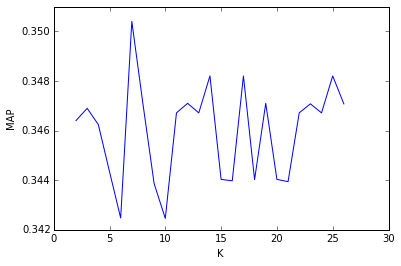

In [218]:
plt.plot(list_K, mp)
plt.xlabel("K")
plt.ylabel("MAP")

In [234]:
maxiter_list = np.arange(20)
mp = np.zeros(maxiter_list.shape[0])
for i, maxiter in enumerate(maxiter_list):
    tfmap = rankingmethod.TFMAP(user_item,K=7, reg=reg, lrate=lrate, verbose=0, maxiter=maxiter)
    tfmap.fit(train)
    mp[i] = rankingmeasure.get_MAP(train, test, tfmap, skip_train=False)
#             climf_validation[i,j,m] = mrr
    print(K, lrate, reg, "MAP", mp[i])
    sys.stdout.flush()

1 0.012 0.012 MAP 0.0042603102535
1 0.012 0.012 MAP 0.00626182368521
1 0.012 0.012 MAP 0.303905284399
1 0.012 0.012 MAP 0.322663639803
1 0.012 0.012 MAP 0.345621137596
1 0.012 0.012 MAP 0.336674549123
1 0.012 0.012 MAP 0.340395384033
1 0.012 0.012 MAP 0.342887816875
1 0.012 0.012 MAP 0.345948732501
1 0.012 0.012 MAP 0.344964371295
1 0.012 0.012 MAP 0.346694728213
1 0.012 0.012 MAP 0.34550920671
1 0.012 0.012 MAP 0.344172657334
1 0.012 0.012 MAP 0.346099129777
1 0.012 0.012 MAP 0.343975911212
1 0.012 0.012 MAP 0.348043574221
1 0.012 0.012 MAP 0.349907932905
1 0.012 0.012 MAP 0.344032664901
1 0.012 0.012 MAP 0.346714276706
1 0.012 0.012 MAP 0.351484424265


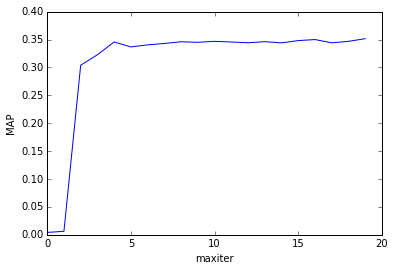

In [236]:
plt.plot(maxiter_list, mp)
plt.xlabel("maxiter")
plt.ylabel("MAP")

In [ ]:
self, user_item, K=10, reg=0.001, lrate=0.001, n_sample=100, maxiter=20, verbose=0)

In [103]:
cf = rankingmethod.TFMAP(user_item, K=10, reg=0.001, lrate=0.01, verbose = 1, maxiter=12)
cf.fit(train)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11


In [102]:
all_measures(train, test, cf)

precK 0.180930760499
1-call5 0.5402951191827469
MRR 0.42529711390083835
AUC 0.630444505232
NGDC 0.207541948703
MAP 0.373795875899


### pureSVD

In [143]:
cf = rankingmethod.pureSVD(user_item,  rate_neg_sample=1000.0, verbose=1)


In [ ]:
cf.fit(train)

In [142]:
all_measures(train, test, cf)

precK 0.00690124858116
1-call5 0.027695800227014757
MRR 0.030906862455593657
AUC 0.806544835437
NGDC 0.0059649372233
MAP 0.0101226510279


In [139]:
all_measures(train, test, cf)

precK 0.00989784335982
1-call5 0.038138479001135074
MRR 0.03823556637728849
AUC 0.805579474585
NGDC 0.0104280871446
MAP 0.0212220961029


## Проведение такого же эксперимента, как у создатей CLiMF

In [ ]:
def climf_experiment(data, list_cf, list_measure, K, maxiter, top=None):
    res = np.zeros((len(list_measure), len(list_cf)))
    for t in range(maxiter):
        start_time = time.time()
        train, test, traintest = givenK_train_test(epinion, K)
        print('create test and train', time.time() - start_time)
        for i, cf in enumerate(list_cf):
            start_time = time.time()
            cf.fit(train)
            print('fit method', time.time() - start_time)
            for j, measure in enumerate(list_measure):
                start_time = time.time()
                res[j, i] += measure(train, test, cf, top=top)
                print('get measure', time.time() - start_time)
            print(t, i, res[:, i] / (t + 1))
            sys.stdout.flush()
    res /= K
    return res

In [ ]:
climf_experiment(epinion, list_cf, list_measure, 5, 1, None)

In [12]:
list_cf = [
    rankingmethod.PopRec(user_item),
    rankingmethod.CLiMF(user_item, K=10, reg=0.001, lrate=0.01, verbose=0, maxiter=10),
    rankingmethod.BPR_MF(user_item, K = 20, lrate=0.012, regIpos=0.012, 
                              regIneg=0.012, regU=0.012, maxiter=4, verbose=0 ),
    rankingmethod.iMF(user_item, K=10, lmbd=0.01, alpha=40, maxiter=30, verbose=0),
    rankingmethod.TFMAP(user_item, lrate=0.01, maxiter=10)
    
]

list_measure = [
    rankingmeasure.get_prec_K,
    rankingmeasure.get_one_recal_K,
    rankingmeasure.get_MRR,
    rankingmeasure.get_AUC,
    rankingmeasure.get_NDCG,
    rankingmeasure.get_MAP
]

In [ ]:
res5 = climf_experiment(epinion, list_cf, list_measure, 5, 5, None)

In [ ]:
for i in range(5, 21, 5):
    res = climf_experiment(epinion, list_cf, list_measure, i, 5, None)
    with open('climf_res' + str(i) +'.pickle', 'wb') as f:
        pickle.dump(res, f)
    res = climf_experiment(epinion, list_cf, list_measure, i, 5, top)
    with open('climf_res_top' + str(i) + '.pickle', 'wb') as f:
        pickle.dump(res, f)

In [ ]:
def show_smart_table(data):
    name_measure = ['precK', '1-recalK', 'MRR', 'AUC', 'NDCG']
    ans = pd.DataFrame()
    ans['measures'] = name_measure
    ans['PopRec'] = data[:, 0]
    ans['CLiMF'] = data[:, 1]
    ans['BRP_MP'] = data[:, 2]
    ans['iMF'] = data[:, 3]
    print(ans)

In [ ]:
for i in range(5, 21, 5):
    with open('climf_res' + str(i) +'.pickle', 'rb') as f:
        tbl = pickle.load(f)
    print('---------')
    print('K =', i)
    show_smart_table(tbl)
    with open('climf_res_top' + str(i) + '.pickle', 'rb') as f:
        tbl = pickle.load(f)
    print('---------')
    print('K =', i, 'without top')
    show_smart_table(tbl)

In [ ]:
show_smart_table(res5)

### Сравнение работы методов

In [13]:
import copy
import sys
class ensemble:
    def __init__(self, list_cf, verbose=0):
        self.list_cf = copy.deepcopy(list_cf)
        self.verbose = verbose
    
    
    def fit(self, data):
        for i in range(len(self.list_cf)):
            self.list_cf[i].fit(data)
            if self.verbose == 1:
                print("iteration", i)
                sys.stdout.flush()
    
    
    def show_all_ulist(self, u, topK=5):
        for i in range(len(self.list_cf)):
            print(type(self.list_cf[i]).__name__, self.list_cf[i].get_list(u)[:topK])

            
def matrix_similar(self, u, topK=5):
    res = []
    for i in range(len(self.list_cf)):
        res.append(self.list_cf[i].get_list(u)[:topK])
    
    ans = np.zeros((len(res), len(res)))
#     print(res)
    for i in range(ans.shape[0]):
        for j in range(i + 1, ans.shape[1]):
#             print(res[i])
#             print(res[j])
            ans[i, j] = np.mean(np.in1d(res[i], res[j]))
            ans[j, i] = ans[i, j]
    return ans


def mean_matrix_similar(self, topK=5):
    N_users = self.list_cf[0].N_users
    for u in range(N_users):
        if u == 0:
            ans = matrix_similar(self, u, topK)
        else:
            ans += matrix_similar(self, u, topK)
    ans /= N_users
    return ans

In [57]:
ens = ensemble(list_cf, verbose=1)

In [58]:
ens.fit(train)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4


In [88]:
mean_matrix_similar(ens, topK=5)

array([[ 0.        ,  0.80068104,  0.99350738,  0.15718502,  0.96286039],
       [ 0.80068104,  0.        ,  0.80485812,  0.15582293,  0.80190692],
       [ 0.99350738,  0.80485812,  0.        ,  0.15741203,  0.95750284],
       [ 0.15718502,  0.15582293,  0.15741203,  0.        ,  0.15723042],
       [ 0.96286039,  0.80190692,  0.95750284,  0.15723042,  0.        ]])

In [89]:
mean_matrix_similar(ens, topK=10)

array([[ 0.        ,  0.90338252,  0.99920545,  0.18208854,  0.64785471],
       [ 0.90338252,  0.        ,  0.9030874 ,  0.18256527,  0.67334847],
       [ 0.99920545,  0.9030874 ,  0.        ,  0.18213394,  0.64735528],
       [ 0.18208854,  0.18256527,  0.18213394,  0.        ,  0.17053348],
       [ 0.64785471,  0.67334847,  0.64735528,  0.17053348,  0.        ]])

### Построение ансамбля

In [50]:
import copy
import sys
class top_ensemble:
    def __init__(self, list_cf, topK = 15, verbose=0):
        self.list_cf = copy.deepcopy(list_cf)
        self.verbose = verbose
        self.topK = topK
        
    
    def get_list(self, u):
        N_items = self.list_cf[1].N_items
        N_methods = len(self.list_cf)
        res = np.zeros((N_methods, N_items))
        for i, num_cf in enumerate(np.random.choice(N_methods, N_methods, replace=False)):
            res[i] = self.list_cf[num_cf].get_list(u)
        
        total_res = res.T.ravel()
        ans = []
        for elem in total_res:
            if elem not in ans:
                ans.append(elem)
            if len(ans) == self.topK:
                break
        return np.array(ans)
    

In [52]:
top_ens = top_ensemble(ens.list_cf, topK=100, verbose=1)

In [49]:
np.random.choice(5, 5, replace=False)

array([0, 2, 1, 4, 3])

### проверка работы ансамбля givenk = 5

In [34]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 5)

array([ 0.20889898,  0.59659478,  0.23334799,  0.40400019])

In [36]:
for cf in top_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

[ 0.19704881  0.55913734  0.22254752  0.38464813]
[ 0.1938252   0.56118048  0.22009766  0.38748802]
[ 0.19523269  0.56072645  0.22107609  0.38591121]
[ 0.17711691  0.52485812  0.18861426  0.32164586]
[ 0.18719637  0.55323496  0.21465356  0.38445958]


In [37]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 10)

array([ 0.17402951,  0.72122588,  0.20026969,  0.37375175])

In [38]:
for cf in top_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 10))

[ 0.16944381  0.68876277  0.19412473  0.35670129]
[ 0.16989784  0.68944381  0.19419015  0.3561263 ]
[ 0.16955732  0.69057889  0.19406199  0.35569465]
[ 0.15768445  0.67309875  0.17098093  0.31099781]
[ 0.15738933  0.65788876  0.18414103  0.35370021]


### проверка работы ансамбля givenk = 10 iMF слишком хорошо работает(

In [59]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 5)

array([ 0.24281498,  0.676958  ,  0.26581623,  0.44658374])

In [60]:
for cf in top_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

[ 0.18320091  0.53416572  0.20701312  0.36450404]
[ 0.1815664   0.53870602  0.20560403  0.36648253]
[ 0.18292849  0.53348468  0.20675077  0.36393303]
[ 0.26115778  0.71577753  0.28306775  0.47061798]
[ 0.17257662  0.51577753  0.19827725  0.35810853]


In [44]:
import time
t = time.time()
a = top_ens.get_list(0, 4000)
print(time.time() - t)

0.31627511978149414


In [97]:
a =np.arange(6*3).reshape(6, 3)
print(a)
print(a.ravel())
print(a.T.ravel())

[[ 0  1  2]
 [ 3  4  5]
 [ 6  7  8]
 [ 9 10 11]
 [12 13 14]
 [15 16 17]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
[ 0  3  6  9 12 15  1  4  7 10 13 16  2  5  8 11 14 17]


In [57]:
ansamble.show_all_ulist(5, 10)

PopRec [  18  721 1042  674  143  118  711  136   34 1536]
CLiMF [  18  674  721 1042 1536  118  143  711  136   34]
BPR_MF [  18 1042  721  674  143  118 1536  136   34  711]
iMF [497 362 378  43   1 379  10  12  79 125]
TFMAP [  18  674 1042  721  711   28  143 3805   34   77]


In [119]:
import copy
import sys
class rating_ensemble:
    def __init__(self, list_cf, weights = None, verbose=0):
        self.list_cf = copy.deepcopy(list_cf)
        self.verbose = verbose
        if weights is None:
            self.weights = np.ones(len(list_cf))/len(list_cf)
        else:
            assert(weights.shape[0] == len(list_cf))
            self.weights = weights
        self.N_items = self.list_cf[1].N_items
        self.N_methods = len(self.list_cf)
        #self.index = np.arange(self.N_items)[::-1] + 1
        self.index = np.exp(-0.5 * np.arange(self.N_items))
        
    def get_list(self, u):
        res = np.zeros(self.N_items)
        for i in range(self.N_methods):
            ranks = self.list_cf[i].get_list(u)
            res[ranks] += self.weights[i] * self.index 
        return np.argsort(-res)
    

### givenK = 5

In [95]:
train5, test5, traintest5 = givenK_train_test(epinion, 5)

In [97]:
ens5 = ensemble(list_cf, verbose=1)
ens5.fit(train5)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4


In [98]:
rating_ens = rating_ensemble(ens5.list_cf)

In [102]:
rankingmeasure.get_Kmetrics(train5, test5, rating_ens, True, K = 5)

array([ 0.20340522,  0.57207719,  0.21539089,  0.35614769])

In [103]:
for cf in rating_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train5, test5, cf, True, K = 5))

[ 0.19723042  0.5523269   0.22281641  0.38555146]
[ 0.19673099  0.55005675  0.22215417  0.38491046]
[ 0.1953689   0.55005675  0.22130483  0.38498266]
[ 0.17734393  0.53461975  0.18653377  0.31993852]
[ 0.18696935  0.54801362  0.21227095  0.37798714]


In [120]:
rating_ens = rating_ensemble(ens5.list_cf)
rankingmeasure.get_Kmetrics(train5, test5, rating_ens, True, K = 5)

array([ 0.20281498,  0.57707151,  0.22675051,  0.39048966])

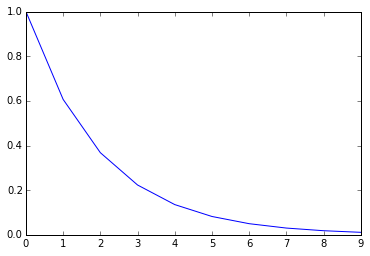

In [117]:
plt.plot(np.exp(-0.5 * np.arange(10)))

In [64]:
for cf in top_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

In [65]:
a

array([4, 4, 2, 2, 8, 7, 1, 2, 0, 6])

In [67]:
np.argsort(-a)

array([4, 5, 9, 0, 1, 2, 3, 7, 6, 8])

In [ ]:
np.argosrt()

In [61]:
a = None

In [63]:
if a is None:
    print("ywe")

ywe


# Slashdot data set

In [127]:
data = pd.read_csv("../datasets/Slashdot0811.txt", sep='\t', header=4)
data = data.as_matrix()

In [128]:
data.shape

(905467, 2)

In [129]:
slashdot, user_item = make_valid_data(data)

In [155]:
list_cf = [
    rankingmethod.PopRec(user_item),
    rankingmethod.CLiMF(user_item, K=10, reg=0.001, lrate=0.01, verbose=0, maxiter=10),
    rankingmethod.BPR_MF(user_item, K = 20, lrate=0.001, regIpos=0.1, 
                              regIneg=0.1, regU=0.1, maxiter=30, verbose=0 ),
    rankingmethod.iMF(user_item, K=10, lmbd=0.01, alpha=40, maxiter=30, verbose=0),
    rankingmethod.TFMAP(user_item, reg=0.001, lrate=0.01, maxiter=12)
    
]

list_measure = [
    rankingmeasure.get_prec_K,
    rankingmeasure.get_one_recal_K,
    rankingmeasure.get_MRR,
    rankingmeasure.get_AUC,
    rankingmeasure.get_NDCG,
    rankingmeasure.get_MAP
]

In [132]:
train, test, traintest = givenK_train_test(slashdot, 5)

In [133]:
poprec = rankingmethod.PopRec(user_item_slash)
poprec.fit(train)
top = poprec.get_list(0)[:3]
# all_measures(train, test, poprec, True, top)
all_measures(train, test, poprec, True)

precK 0.122225400458
1-call5 0.37528604118993136
MRR 0.273406086512
AUC 0.776325504811
NGDC 0.131158605935
MAP 0.227184043669


### givenk = 5

In [138]:
slash_ens = ensemble(list_cf, verbose=1)

In [139]:
slash_ens.fit(train)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4


In [140]:
for cf in slash_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

[ 0.1222254   0.37528604  0.13115861  0.22718404]
[ 0.12233982  0.37585812  0.13122573  0.22734037]
[ 0.12268307  0.37585812  0.1314579   0.227249  ]
[ 0.10420481  0.33495423  0.10975777  0.19563589]
[ 0.12062357  0.37628719  0.12923841  0.22546283]


In [141]:
top_ens = top_ensemble(slash_ens.list_cf, topK=100)

In [142]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 5)

array([ 0.12402746,  0.39487986,  0.13112244,  0.23042843])

### givenk = 10

In [156]:
train, test, traintest = givenK_train_test(slashdot, 10)

In [157]:
slash_ens = ensemble(list_cf, verbose=1)
slash_ens.fit(train)

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4


In [158]:
poprec = rankingmethod.PopRec(user_item)
poprec.fit(train)
top = poprec.get_list(0)[:3]
#all_measures(train, test, poprec, True, top)
rankingmeasure.get_Kmetrics(train, test, poprec, True, K=5)

array([ 0.10918192,  0.3506865 ,  0.11928689,  0.21512741])

In [159]:
for cf in slash_ens.list_cf:
    print(rankingmeasure.get_Kmetrics(train, test, cf, True, K = 5))

[ 0.10918192  0.3506865   0.11928689  0.21512741]
[ 0.10918192  0.3506865   0.11928689  0.21512741]
[ 0.10943936  0.35054348  0.11506516  0.2026143 ]
[ 0.13667048  0.40789474  0.14297494  0.24199681]
[ 0.10918192  0.3506865   0.11928901  0.21513456]


### Сравнение глазками

In [162]:
for cf in slash_ens.list_cf:
    print(type(cf).__name__)
    print(cf.get_list(0)[:15])

PopRec
[4668  394 2481  225 8848 4690 5043 3443  377  217 5390   34 2470 3444   46]
CLiMF
[4668  394 2481  225 8848 4690 5043 3443  377 5390   34  217 2470   46 2539]
BPR_MF
[ 394 2481 4668  225 8848  217 4690  377 5043 3443   46 5390 2470   34  403]
iMF
[2481 4668  143  151  205   15 4845   59 3369 3947 4979  186  400 5367 3083]
TFMAP
[4668  394 2481  225 8848 4690 5043 3443  377 3444  403  217 5390 5705 7450]


In [150]:
rankingmeasure.get_Kmetrics(train, test, top_ens, True, K = 5)

array([ 0.15946796,  0.51001144,  0.16663805,  0.29156159])

# старые эксперименты

In [ ]:
a = np.arange(10)
b = a[1:4]
print(a)
print(b)
b[2] = 100
a[1] = -a[1]
print(a)
print(b)

In [ ]:
tmp = mmread("../datasets/epinions_original/EP25_UPL5_test.mtx")
test = np.array(list(zip(tmp.row, tmp.col)))
tmp = mmread("../datasets/epinions_original/EP25_UPL5_train.mtx")
train = np.array(list(zip(tmp.row, tmp.col)))
user_item = [max(np.max(test[:,0]), np.max(train[:, 0])) + 1, max(np.max(test[:,1]), np.max(train[:,1])) + 1]

In [ ]:
train = create_listarray(train)
test  = create_listarray(test)

In [ ]:
create_csr(train, user_item, '../pyCLiMF-master/good_train.pickle')
create_csr(test, user_item, '../pyCLiMF-master/good_test.pickle')

In [ ]:
randomrec = rankingmethod.RandomRec(user_item)
randomrec.fit(train)
all_measures(train, test, randomrec, False)

In [ ]:
poprec = rankingmethod.PopRec(user_item)
poprec.fit(train)
top = poprec.get_list(0)[:3]
# all_measures(train, test, poprec, True, top)
# all_measures(train, test, poprec, True)

In [ ]:
rankingmeasure.get_AUC(train, test, poprec, True, K=user_item[1])

In [ ]:
rankingmeasure.get_NDCG(train, test, poprec, True, K = 5)

In [ ]:
rankingmeasure.get_NDCG(train, test, poprec, True, K = 3)

In [ ]:
index_user = np.random.choice(len(train), 100, replace=False)


In [ ]:
orig_train = create_original_sample(train, index_user)
orig_test = create_original_sample(test, index_user)

In [ ]:
climf = rankingmethod.CLiMF(user_item, lrate = 0.0001, reg=0.001, maxiter=15, verbose=2)
climf.fit(train)

In [ ]:
rankingmeasure.get_MRR(train, test, climf, True)

In [ ]:
all_measures(train, test, climf, True, top)

In [ ]:
all_measures(train, test, climf, True)

In [ ]:
climf = rankingmethod.CLiMF(user_item, maxiter=40, lrate = 0.1, verbose=2)
climf.fit(train)


In [ ]:
all_measures(train, test, climf, False)

In [ ]:
all_measures(train, test, climf, True, top)

In [ ]:
list_reg = [0.001, 0.002, 0.005, 0.0005]
list_lrate = [0.05, 0.07, 0.1, 0.12, 0.15 ]
list_K = [10, 12, 15, 7, 5]
times_count = 3

for K, lrate, reg in itertools.product(list_K, list_lrate, list_reg):
    MRR = 0
    
    for t in range(times_count):
        climf = rankingmethod.CLiMF(user_item,K=K, reg=reg, lrate=lrate, verbose=0, maxiter=50)
        climf.fit(train)
        MRR += rankingmeasure.get_MRR(train, test, climf, skip_train=False)
    print("K", K, "lrate", lrate, "reg", reg, "MRR", MRR/times_count)
    sys.stdout.flush()

In [ ]:
bpr_mf = rankingmethod.BPR_MF(user_item, K = 20, lrate=0.001, regIpos=0.1, 
                              regIneg=0.1, regU=0.1, maxiter=30, verbose=2 )

In [ ]:
bpr_mf.fit(train)

In [ ]:
all_measures(train, test, bpr_mf, True)

In [ ]:
rankingmeasure.get_AUC(train, test, bpr_mf, True, K=user_item[1])

In [ ]:
rankingmeasure.get_NDCG(train, test, bpr_mf, True, K=5)

In [ ]:
imf = rankingmethod.iMF(user_item, K=20, lmbd=0.01, alpha=40, maxiter=30, verbose=2)

In [ ]:
imf.fit(train)

In [ ]:
all_measures(train, test, imf, True)

In [ ]:
all_measures(train, test, imf, True, top)

In [ ]:
all_measures(train, test, bpr_mf, True, top)

In [ ]:
all_measures(train, test, poprec, True)

In [ ]:
all_measures(train, test, poprec, True, top)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
a = np.array([False,False, True, True])
b = np.array([0,2,1,3])
print(roc_auc_score(a, b, average=None))

In [ ]:
(a == True).any()

In [ ]:
import random

In [ ]:
random.sample(range(10), 3)